# Datasets과 Dataloader 

데이터 샘플을 처리하는 코드는 messy(지저분)하고 유지보수가 어려울 수 있다.</br>
더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다. </br>
pytorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두 가지 데이터 기본 요소를 제공하여 미리 준비된 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.</br>
Dataset은 샘플과 라벨을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.</br>
</br>
pytorch의 도메인 특화 라이브러리들은 다양한 pre-loaded 데이터셋을 제공한다.</br>
데이터셋은 torch.utils.data.Dataset의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다.</br>
이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있다.</br>

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 데이터셋 불러오기
torchvision에서 Fashion MNIST 데이터셋 불러오기

train 60,000개 

test 10,000개

grayscale 28x28 

10개 분류 중 하나인 label로 구성


In [4]:

training_data = datasets.FashionMNIST(root="data",
train=True, download=True, transform=ToTensor())

test_data = datasets.FashionMNIST(root="data",
train=False, download=True, transform=ToTensor())


C:\Users\JIYEON\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 데이터셋 순회 & 시각화

Dataset에 list처럼 직접 접근(index)할 수 있다->training_data[index]

matplotlib를 사용해서 학습 데이터의 일부를 시각화해보자

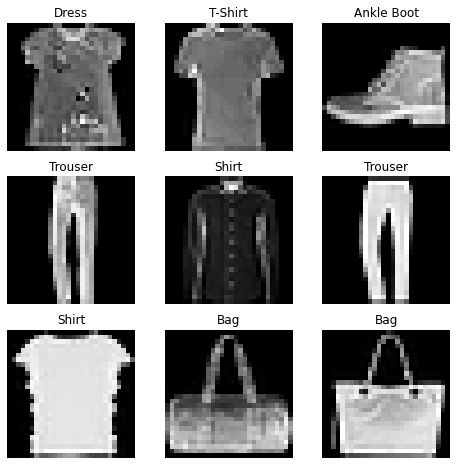

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # print(sample_idx)

    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()


# 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다.

1. __init__
2. __len__
3. __getitem__



In [11]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self, idx): # sample data length
        return len(self.img_labels)

    def __getitem__(self, idx): # idx에 맞는 데이터 불러오기
        img_path = os.path.join(self.img_dir, self.img_label.iloc[idx,0])
        image = read_image(img_path) # tensor로 변환 
        label = self.img_labels.iloc[idx,1] 
        
        # 텐서와 라벨을 dict 형태로 변환 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# DataLoader로 학습용 데이터 준비
Dataset은 데이터의 feature를 가져오고 하나의 샘플에 label을 지정하는 일을 한 번에 한다.

모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고 매 에폭마다 데이터를 다시 섞어 과적합을 막고, 파이썬의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 한다.

DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 iterable(객체)이다.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


# DataLoader를 통회 순회(iterate)

DataLoader에 데이터셋을 불러온 뒤 필요에 따라 iterate 할 수 있다.

아래의 각 iteration은 train_features와 train_label의 batch를 반환


Feature batch shape
torch.Size([64, 1, 28, 28])
Labels batch size
torch.Size([64])


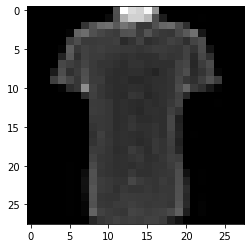

6


In [20]:
train_features, train_labels = next(iter(train_dataloader))
print("Feature batch shape")
print(train_features.size())
print("Labels batch size")
print(train_labels.size())

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(label.item())


# Transform 변형

Transform을 통해 데이터를 학습에 적합하게 처리한다.

모든 torchvision 데이터셋들은 변형 로직을 갖는, 호출 가능한 객체(callable)를 받는 매개변수 두개(feature를 변형하기 위한 transform, label을 변형하기 위한 target_transform)를 갖는다.

torchvision.transforms 모듈은 주로 사용하는 몇 가지 transform을 제공한다.

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root='data', train=True, download=True, transform=ToTensor(),
    target_transform=Lambda(
        lambda y:torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
"""
ToTensor()
PIL image나 numpy ndarry를 floattensor로 변환하고
이미지의 픽셀 크기0~1 범위로 비례하여 조정 (scale)

Lambda 변형
사용자 정의 lambda 함수를 적용한다.
여기서 정수를 one-hot으로 부호화된 텐서로 바꾸는 함수 정의

이 함수는 먼저 데이터셋 정답의 개수 크기 10짜리 zero tensor를 만들고,
scatter_를 호출하여 주어진 정답 y에 해당하는 인덱스에 value=1을 할당한다.



"""



'\nToTensor()\nPIL image나 numpy ndarry를 floattensor로 변환하고\n이미지의 픽셀 크기0~1 범위로 비례하여 조정 (scale)\n\nLambda 변형\n사용자 정의 lambda 함수를 적용한다.\n여기서 정수를 one-hot으로 부호화된 텐서로 바꾸는 함수 정의\n\n이 함수는 먼저 데이터셋 정답의 개수 크기 10짜리 zero tensor를 만들고,\nscatter_를 호출하여 주어진 정답 y에 해당하는 인덱스에 value=1을 할당한다.\n\n\n\n'

In [ ]:
target_transform = Lambda(lambda y:torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [ ]:
target_transform

Lambda()